In [8]:
import numpy as np
import pytesseract
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [52]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [18]:
print(pytesseract.image_to_string(Image.open('./test_imgs/photo_2023-01-14_16-32-26.jpg')))


MSs ULOE 2529

lable No: 254
DINE IN
Receipt No .69980 GARDENS_GARDENS_01
Shift No.4 09-Jan-2023
PAX :
Cashier :CASHIER 09-01-23 22:22:52
QTY ITEM NAME AMOUNT
1 N35 Mee Goreng 5.50
2 N33 Maggi Goreng Ayam (Chi.. 17.00
1 N36 Mee Goreng Ayam (Chick... 8.50
2 N32 Maggi Goreng 11.00
] P31 Banana Prata 3,80
5 032 Iced Milo 12.50
1. D40 Iced Teh 0 1.90
1 D65 Blueberry/Syrup/Lime J.. 2.00
Sub Total 62.20
GST 4.97

Grand Tota]
Master Card




In [16]:
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [17]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

-1

In [ ]:
img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')



In [ ]:

denoised = cv2.fastNlMeansDenoisingColored(img,None,7,20,7,21)
# cv2.imshow('denoised', denoised)
# cv2.waitKey(0) 


In [33]:
bw_image = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(bw_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
cv2.imshow('img', th3)
cv2.waitKey(0) 


-1

In [30]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)


def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    print('MorphologyEx done.')
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 4, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    plt.imshow(mask2)
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    print('GaussianBlur done.')
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
 
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    print('Contour Approximation done.')
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)
 
    destination_corners = find_dest(corners)

    print('Destination corners found.')
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final


In [31]:
img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')


MorphologyEx done.
GaussianBlur done.
Contour Approximation done.
Destination corners found.


-1

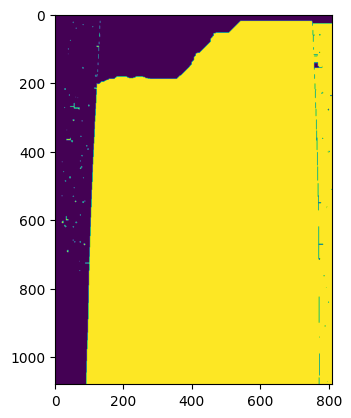

In [32]:
scanned = scan(img)
cv2.imshow('scanned', scanned)
cv2.waitKey(0)

### chatgpt implementation??

In [69]:
import numpy as np

def order_points(pts):
    # Initialize a list of coordinates that will be ordered such that the first entry in the list is the top-left, the second entry is the top-right, the third is the bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # The top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Now, compute the difference between the points, the top-right point will have the smallest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    print(rect)
    # Return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # Obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left x-coordinates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image, which will be the maximum distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Now that we have the dimensions of the new image, construct the set of destination points to obtain a "birds eye view", (i.e. top-down view) of the image, again specifying points in the top-left, top-right, bottom-right,
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # plt.imshow(warped)
    # Return the warped image
    return warped

In [81]:
import cv2
import numpy as np

img = cv2.imread('shadows.png', -1)


def remove_shadow(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
        
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        # result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
        
    # result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    cv2.imwrite('shadows_out_norm.png', result_norm)
    return result_norm
    # cv2.imwrite('shadows_out.png', result)


True

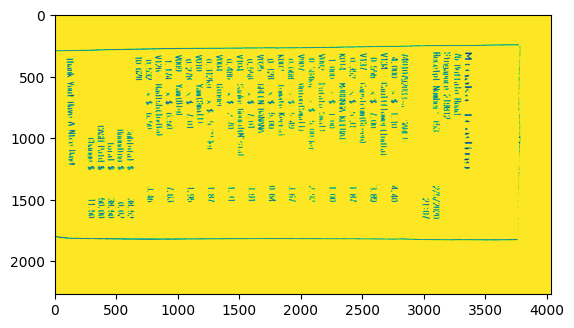

In [134]:
import cv2

# Load the image
image = cv2.imread('./test_imgs/receipts/604.jpg')
denoised = cv2.fastNlMeansDenoisingColored(image,None,7,20,7,21)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = remove_shadow(gray)
# denoised = cv2.fastNlMeansDenoisingColored(img,None,7,20,7,21)


# # Apply adaptive thresholding
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# cv2.imwrite('thresh.png', thresh)
# kernel = np.ones((5,5),np.uint8)
# thresh = cv2.dilate(thresh,kernel,iterations = 1)
# thresh = cv2.erode(thresh,kernel,iterations = 1)

# cv2.imwrite('thresh2.png', thresh)
# Find contours
# contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# # Sort contours by area and keep only the largest ones
# contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]


# # Iterate over the contours
# for cnt in contours:
#     # Approximate the contour
#     approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)

#     # If the contour has 4 vertices, then assume it is a document
#     if len(approx) == 4:
#         docCnt = approx
#         break
# print(docCnt)
# # Extract the document from the image
# perspective = four_point_transform(image, docCnt.reshape(4, 2))

# Apply Otsu threshold
# gray = cv2.cvtColor(perspective, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            # cv2.THRESH_BINARY,11,2)

# Save the scanned image
plt.imshow(thresh)
cv2.imwrite('scanned.png', thresh)


In [135]:
# options = "--psm 4"
# text = pytesseract.image_to_string(
# 	cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB),
# 	config=options)
# print(text)
print(pytesseract.image_to_string(Image.open('./scanned.png')))


Metvverkee Dao cvebbaaveg
(Oo Bat talo Road
etngapore @ lBT2

ecedpt Numbers 153 21 if 2020
21:0
MAQVO TYPOS dea SAREE
4,000 $ 110 A. A0
VBA Cault Hrower Ciidiad
0. ot $2.00 3. BY
WY Cape feum (Green)
O86? ox § Hol | 8!
KOT MURUNGA KEL RAL
hou oy ft aw 100
VO Potato Gmall
Q oBAKY en eee A oN
WOOF Undone Comal)
Q.068 ox bb dy 3.6
KOU? Fonte Keer ad
0. 128 fo OU () 6
VO Gist EN ANANE,
Ga on BCU 494
V0d  Sanbe Gaur dty’ stad
0. ANG f 10 1. 4]
QUd Ginger
O.30ka ox BA bg | 8/
VOIO | Yam (Smal
ORB xb 2a 1, by
vood — Yam(bia)
ee ee oe (608
VIPH Radish (lndtad
Oye oo he 6. 5 dob
10. O08
Stblatab SH
Ravina a0)
loval 4 Rie
CAGE Pala HO. OU
Chatiae 1 hu

Hank Yout Have A Ntee Dayt



{'page_num': 0, 'orientation': 270, 'rotate': 90, 'orientation_conf': 0.15, 'script': 'Cyrillic', 'script_conf': 0.67}


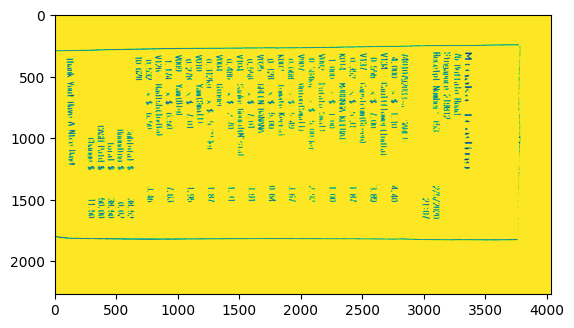

In [136]:
# image = cv2.imread(args["image"])
# import os
# for img in os.listdir('./test_imgs/receipts'):
#     print(img)
import imutils
# from pyte
img = cv2.imread('./scanned.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
# rgb = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
results = pytesseract.image_to_osd(thresh, output_type=pytesseract.Output.DICT)
print( results)
rotated = imutils.rotate_bound(thresh, angle=-results["rotate"])
# plt.imshow(rotated)
# results2 = pytesseract.image_to_osd(rotated, output_type=pytesseract.Output.DICT)
# print(results2)

In [137]:
print(pytesseract.image_to_string(rotated))


Metuvahee Dat cvebbnacy
(O Battato Road
“tngapate ¢ Wel?

Recedpt Nomber’ 153 2 ff 2020
PLOf
MAQVO TYPOS dea SAREE
A000 x $ 110 A. A0
VBA Cault Hrower Ciidiad
O54 ss $ 700 3.89)
VIG2 Caps feu (Gi eon)
O86? ox § Hol | 8!
KOT MURUNGA KEL RAL |
Cee LD 100
VO Potato Gmall
Q oBAKY en eee A oN
WOOF Undone Comal)
O.b68 os bb ay 3.0/
KOO? Lomato Keer ad
QO 1P8 ox fh 200 () 6A
VO Gist EN ANANE,
Ga on BCU 494
V0d  Sanbe Gaur dty’ stad
OA ox § 7 10 1.4]
VOUd Ginger
Oo 32ka ox baby | 8/
VOIO Yam (inal)
ORB xb 2a ue
vood — Yam(bia)
ee ee oe (608
VIPH Radish (lndtad
Oye oo he 6. 5 dob
10. 008
Stblatab SH
Ravina a0)
loral $ 3H. bu
CAGE Pala HO, OU
Chatiae 1 hu

Hank Yout Have A Ntee Dayt

